In [39]:
from pyspark.sql import SparkSession,Window
import pyspark.sql.functions as f
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder.appName("FootballAnalysis").master("local[3]").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/02 11:39:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read\
        .format("csv")\
        .option("header","true")\
        .option("inferSchema","true")\
        .load("/Users/mohan/Desktop/PySpark/wrangling__pyspark/Data/Matches.csv")
#Rename Column
old_col = df.columns[-3:]
new_col = ['HomeTeamGoals','AwayTeamGoals','FinalResult']
col = zip(old_col,new_col)
for old,new in col:
    df = df.withColumnRenamed(old,new)
df = df.withColumn('HomeTeamWin', f.when(f.col('FinalResult') == 'H', 1).otherwise(0)) \
                        .withColumn('AwayTeamWin', f.when(f.col('FinalResult') == 'A', 1).otherwise(0)) \
                        .withColumn('GameTie', f.when(f.col('FinalResult') == 'D', 1).otherwise(0))

In [5]:
#checking null values in all Columns
null_values = [df.filter(f.col(column).isNull()).count() for column in df.columns]
null_values

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

23/10/02 11:39:38 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [6]:
# Q1 . Who are the winners of the D1 division in the Germany Football Association (Bundesliga) in the last decade?
bundesliga = df.filter(f.expr("Div='D1' and Season>=2000 and Season<=2010"))

home = bundesliga.groupBy("Season","HomeTeam")\
                .agg(f.sum("HomeTeamWin").alias("TotalHomeWin"),
                    f.sum("AwayTeamWin").alias("TotalHomeLoss"),
                    f.sum('GameTie').alias('TotalHomeTie'), 
                     f.sum('HomeTeamGoals').alias('HomeScoredGoals'),
                     f.sum('AwayTeamGoals').alias('HomeAgainstGoals')
                    ).withColumnRenamed('HomeTeam','Team')

away = bundesliga.groupBy("Season","AwayTeam")\
                .agg(f.sum("AwayTeamWin").alias("TotalAwayWin"),
                    f.sum("HomeTeamWin").alias("TotalAwayLoss"),
                    f.sum('GameTie').alias('TotalAwayTie'), 
                     f.sum('AwayTeamGoals').alias('AwayScoredGoals'),
                     f.sum('HomeTeamGoals').alias('AwayAgainstGoals')
                    ).withColumnRenamed('AwayTeam','Team')

window = Window.partitionBy('Season').orderBy(f.col('win_pct').desc(),f.col('GoalDifferentials').desc())

table = home.join(away,how='inner',on=['Season','Team'])\
            .withColumn('Win',f.col('TotalHomeWin') + f.col('TotalAwayWin'))\
            .withColumn('Loss',f.col('TotalHomeLoss') + f.col('TotalAwayLoss'))\
            .withColumn('Tie',f.col('TotalHomeTie') + f.col('TotalAwayTie'))\
            .withColumn('win_pct',f.round(f.col('Win')*100/(f.col('Win')+f.col('Loss')+f.col('Tie')),2))\
            .withColumn('GoalsScored',f.col('HomeScoredGoals') + f.col('AwayScoredGoals'))\
            .withColumn('GoalsAgainst',f.col('HomeAgainstGoals') + f.col('AwayAgainstGoals'))\
            .withColumn('GoalDifferentials',f.col('GoalsScored') - f.col('GoalsAgainst'))\
            .withColumn('position',f.rank().over(window))\
            .select('Season','Team','Win','Loss','Tie','win_pct','GoalsScored','GoalsAgainst','GoalDifferentials','position')
            
table_df = table.where(f.col('position')==1).toPandas()


In [7]:
table_df

,Season,Team,Win,Loss,Tie,win_pct,GoalsScored,GoalsAgainst,GoalDifferentials,position
0,2000,Bayern Munich,19,9,6,55.88,62,37,25,1
1,2001,Leverkusen,21,7,6,61.76,77,38,39,1
2,2002,Bayern Munich,23,5,6,67.65,70,25,45,1
3,2003,Werder Bremen,22,4,8,64.71,79,38,41,1
4,2004,Bayern Munich,24,5,5,70.59,75,33,42,1
5,2005,Bayern Munich,22,3,9,64.71,67,32,35,1
6,2006,Stuttgart,21,6,7,61.76,61,37,24,1
7,2007,Bayern Munich,22,2,10,64.71,68,21,47,1
8,2008,Wolfsburg,21,7,6,61.76,80,41,39,1
9,2009,Bayern Munich,20,4,10,58.82,72,31,41,1


In [8]:
# Q2. Which teams have been relegated in the past 10 years?
relegated_teams = table.where(f.expr('position=18 or position=17 or position=16')).toPandas()

In [9]:
relegated_teams

,Season,Team,Win,Loss,Tie,win_pct,GoalsScored,GoalsAgainst,GoalDifferentials,position
0,2000,Stuttgart,9,14,11,26.47,42,49,-7,16
1,2000,Unterhaching,8,15,11,23.53,35,59,-24,17
2,2000,Bochum,7,21,6,20.59,30,67,-37,18
3,2001,Freiburg,7,18,9,20.59,37,64,-27,16
4,2001,FC Koln,7,19,8,20.59,26,61,-35,17
5,2001,St Pauli,4,20,10,11.76,37,70,-33,18
6,2002,Bielefeld,8,14,12,23.53,35,46,-11,16
7,2002,Nurnberg,8,20,6,23.53,33,60,-27,17
8,2002,Cottbus,7,18,9,20.59,34,64,-30,18
9,2003,Munich 1860,8,18,8,23.53,32,55,-23,17


In [33]:
# Q3.Does Octoberfest affect the performance of Bundesliga?
oktober_fest = df.filter(f.col('Div')=='D1')\
                .where(f.expr('season<=2010 and season > 2000'))\
                .withColumn('Month',f.month('Date'))\
                .withColumn('MonthName',f.date_format('Date','MMMM'))\
                .groupby('Month','MonthName')\
                .agg(f.sum(f.col('HomeTeamGoals')+f.col('AwayTeamGoals')).alias('Goals'),
                    f.sum(f.col('GameTie')).alias('GameTie'),
                    f.count(f.col('FinalResult')).alias('Total')
                    )\
                .withColumn('Goals_to_games_ratio', f.round(f.col('Goals')/f.col('Total'), 1)) \
                .withColumn('GameTie_to_games_ratio', f.round(f.col('GameTie')/f.col('Total'), 1))

In [34]:
oktober_fest.toPandas()

,Month,MonthName,Goals,GameTie,Total,Goals_to_games_ratio,GameTie_to_games_ratio
0,1,January,360,26,131,2.7,0.2
1,8,August,809,80,280,2.9,0.3
2,11,November,1045,83,351,3.0,0.2
3,9,September,904,79,321,2.8,0.2
4,3,March,973,88,351,2.8,0.3
5,7,July,14,2,8,1.8,0.3
6,12,December,706,85,254,2.8,0.3
7,10,October,950,74,325,2.9,0.2
8,5,May,920,58,281,3.3,0.2
9,2,February,1018,103,380,2.7,0.3


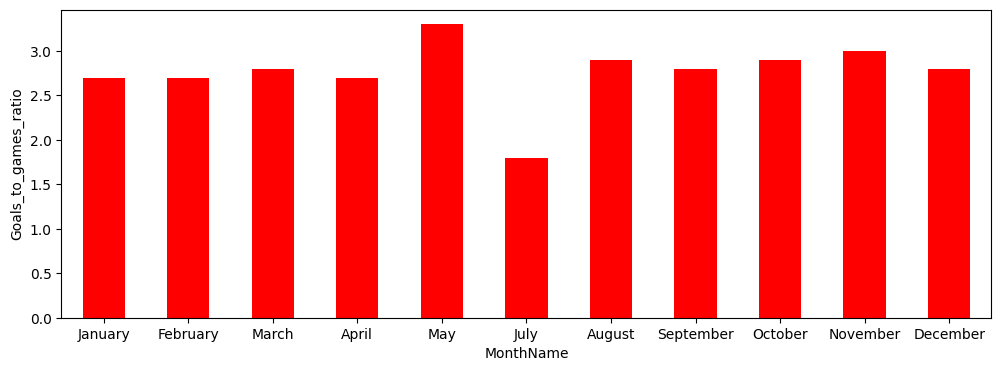

In [40]:
#analysing
oktoberfest_df = oktober_fest.toPandas()
oktoberfest_df = oktoberfest_df.sort_values('Month')
oktoberfest_df.set_index('MonthName', drop=True, inplace=True)
oktoberfest_df['Goals_to_games_ratio'].plot.bar(rot=0, color='red', figsize=(12, 4))
plt.ylabel('Goals_to_games_ratio')
plt.show()

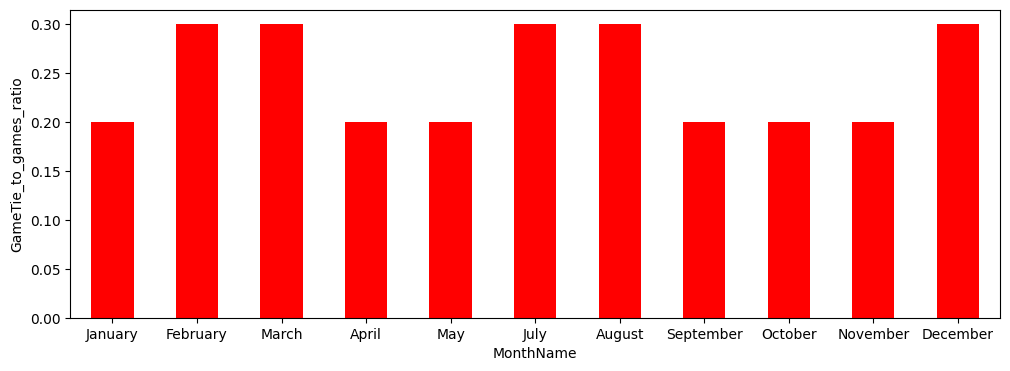

In [41]:
oktoberfest_df['GameTie_to_games_ratio'].plot.bar(rot=0, color='red', figsize=(12, 4))
plt.ylabel('GameTie_to_games_ratio')
plt.show()

In [42]:
# Q5. What's the best month to watch Bundesliga?
# Based on the above graph we can say that May is the best time to watch Bundesliga as most goals are scored in that time 
# and least number of games are tied

SyntaxError: invalid syntax (3874875225.py, line 2)

In [89]:
result.show()

+------+-------------+------------------+
|season|       winner|               gap|
+------+-------------+------------------+
|  2000|Bayern Munich| 2.940000000000005|
|  2001|   Leverkusen|               0.0|
|  2002|Bayern Munich|17.650000000000006|
|  2003|Werder Bremen|5.8899999999999935|
|  2004|Bayern Munich|11.770000000000003|
|  2005|Bayern Munich|2.9499999999999957|
|  2006|    Stuttgart|               0.0|
|  2007|Bayern Munich|5.8899999999999935|
|  2008|    Wolfsburg|2.9399999999999977|
|  2009|Bayern Munich|2.9399999999999977|
|  2010|     Dortmund| 8.830000000000005|
+------+-------------+------------------+

